In [8]:
import torch.nn as nn
import os
import torch.nn.functional as F
from collections import Counter
from torchvision import transforms, datasets
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl

In [9]:
BATCH_SIZE = 64
EPOCHS = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 10
LEARING_RATE = 0.001


In [10]:
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transforms.ToTensor())

100.0%


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [11]:
train_dataloder = DataLoader(dataset=train_dataset, 
                             batch_size=BATCH_SIZE, 
                             shuffle=True, 
                             num_workers=NUM_WORKERS)

test_dataloder = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS)

class_names = train_dataset.classes

train_dataloder, test_dataloder, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f7a611e3d00>,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

torch.Size([64, 3, 32, 32]) torch.Size([64])


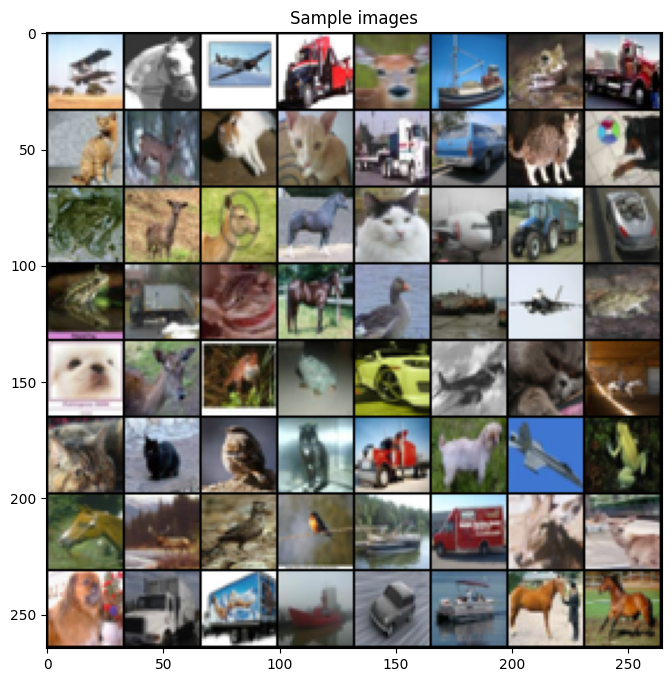

In [12]:
for image, label in train_dataloder:
    print(image.size(), label.size())
    break

plt.figure(figsize=(8, 8))
plt.title('Sample images')
plt.imshow(np.transpose(torchvision.utils.make_grid(image[:64], padding=1, normalize=True), (1, 2, 0)))
plt.show()


In [13]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data_path = '../data'):
        super().__init__()
        self.data_path = data_path
        
    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, download=True)
        
        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
            transforms.Resize((70, 70)),
            transforms.RandomCrop((64,64)),
            transforms.ToTensor()
        ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize((70, 70)),
            transforms.ToTensor()
        ])
        
    def setup(self, stage=None):
        train = datasets.CIFAR10(root=self.data_path, train=True, transform=self.train_transform)
        self.test = datasets.CIFAR10(root=self.data_path, train=False, transform=self.test_transform)
        
        self.train, self.val = random_split(train, [45000, 5000])
        
    def train_dataloader(self):
        
        train_dataloder = DataLoader(dataset=self.train,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)
        
        return train_dataloder
    
    def val_dataloader(self):
            
            val_dataloder = DataLoader(dataset=self.val,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)
            
            return val_dataloder
    
    def test_dataloader(self):
            
            test_dataloder = DataLoader(dataset=self.test,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)
            
            return test_dataloder


In [14]:
class PyTorchmodel(nn.Module): 
    def __init__(self, num_classes): 
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride = 4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return x
            

In [15]:
class LightModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        if hasattr (model, 'dropout_proba'):
            self.dropout_proba = model.dropout_proba
        
        self.save_hyperparameters(ignore='model')
        
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        
    def forward(self, x):
        return self.model(x)
    

    def shared_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        predicted_labels = torch.argmax(logits, 1)
        
        return loss, y, predicted_labels
    
    def training_step(self, batch, batch_idx):
        loss, y, predicted_labels = self.shared_step(batch)
        self.log("train_loss", loss)
        
        self.model.eval()
        with torch.inference_mode(): 
            _, y, predicted_labels = self.shared_step(batch)
        
        self.train_acc(predicted_labels, y)
        self.log("train_acc", self.train_acc, on_step=True, on_epoch=False)
        
        self.model.train()
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, y, predicted_labels = self.shared_step(batch)
        self.log("val_loss", loss)
        
        self.val_acc(predicted_labels, y)
        self.log("val_acc", self.val_acc, on_step=True, on_epoch=False)
        
        
    def test_step(self, batch, batch_idx):
        loss, y, predicted_labels = self.shared_step(batch)
        self.log("test_loss", loss)
        
        self.test_acc(predicted_labels, y)
        self.log("test_acc", self.test_acc, on_step=True, on_epoch=False)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [16]:
model = PyTorchmodel(num_classes=10)

In [17]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

lightning_model = LightModel(model, learning_rate=LEARING_RATE)

callbacks = [ModelCheckpoint(save_top_k=1, mode='max', monitor='val_acc')]

logger = CSVLogger(save_dir = 'logs/', name='cifar10')
    

In [18]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")



tensor([1.], device='mps:0')


In [57]:
import time 

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=callbacks,
    logger=logger, 
    accelerator='auto', 
    devices= 'auto', 
    deterministic=False,
    log_every_n_steps=10

)

start_time = time.time()
trainer.fit(lightning_model, datamodule=DataModule())

runttime = time.time() - start_time
print(f"Training time: {runttime:.2f} seconds")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchmodel       | 57.0 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
57.0 M    Trainable params
0         Non-trainable params
57.0 M    Total params
228.179   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/maximilianruess/Documents/GitHub/DeepLearning_101/dl_101/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/maximilianruess/Documents/GitHub/DeepLearning_101/dl_101/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [03:13<00:00,  3.64it/s, v_num=1]

MisconfigurationException: `ModelCheckpoint(monitor='val_acc')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'epoch', 'step']. HINT: Did you call `log('val_acc', value)` in the `LightningModule`?